In [1]:
pip install google-cloud-storage --quiet

Note: you may need to restart the kernel to use updated packages.


/Applications/anaconda3/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Applications/anaconda3/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


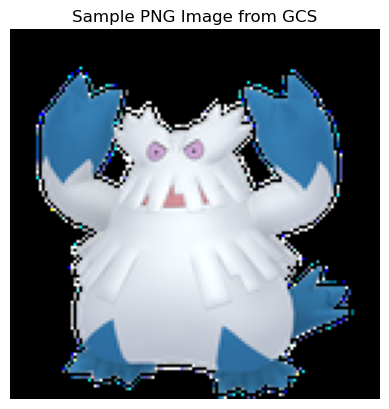

In [4]:
from google.cloud import storage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import io
import matplotlib.pyplot as plt

# Initialize GCS Client
BUCKET_NAME = "mlops_bucket100"
FOLDER_PATH = "data/processed"

client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

# Custom Dataset to Load PNG Images from GCS
class GCSImageDataset(Dataset):
    def __init__(self, bucket, folder_path, transform=None):
        self.bucket = bucket
        self.folder_path = folder_path
        self.transform = transform
        
        # List all PNG files in the folder
        self.image_blobs = [
            blob for blob in bucket.list_blobs(prefix=folder_path) 
            if blob.name.endswith(".png")
        ]

    def __len__(self):
        return len(self.image_blobs)

    def __getitem__(self, idx):
        # Get blob and read its content into memory
        blob = self.image_blobs[idx]
        image_data = blob.download_as_bytes()
        
        # Open image with PIL
        image = Image.open(io.BytesIO(image_data)).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Initialize Dataset and DataLoader
dataset = GCSImageDataset(bucket, FOLDER_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Display a Sample Image
if len(dataset) > 0:
    sample_image = dataset[0]  # Get the first image (transformed)
    plt.imshow(sample_image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC for display
    plt.axis("off")
    plt.title("Sample PNG Image from GCS")
    plt.show()
else:
    print("No PNG images found in the specified folder.")
